Los físicos usan aceleradores de partículas, como el [Gran Colisionador de Hadrones](https://es.wikipedia.org/wiki/Gran_colisionador_de_hadrones) ubicado en la frontera entre Suiza y Francia, para descubrir nuevas partículas subatómicas.

La detección de estas partículas usualmente es un problema de clasificación, para determinar si el dato observado corresponde a la señal de interés o al ruido de fondo.

La idea es desarrollar un modelo de Deep Learning capaz de realizar esta clasificación.

# Data Set

El set de datos fue desarrollado por investigadores del Departamento de Física y Astronomía de la Universidad de California Irvine.

En total contiene 11 millones de datos, cada uno representado por 28 características (*features*):

- Las primeras 21 corresponden a propiedades cinemáticas medidas por los detectores de partículas en el acelerador.
- Las 7 características restantes son calculadas a partir de las 21 anteriores, y fueron derivadas por los físicos para facilitar el proceso de clasificación.

Cada dato está etiquetado en una de dos posibles características:

- "1": presencia de señal (posiblemente una partícula)
- "0": ruido de fondo (no corresponde a una partícula)

[Searching for Exotic Particles in High-Energy Physics with Deep Learning](https://arxiv.org/pdf/1402.4735.pdf)

Para esta práctica se trabajará con una versión reducida del mismo (*HIGGS_subset.csv*) que contiene un total de 100.000 datos.

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import SGD  # GD Estocástico para mac
from tensorflow.keras.optimizers.legacy import Adam # ADAM para mac

import tensorflow as tf
import numpy as np

# Lectura y visulización

In [72]:
import chardet

def open_file(path):
    # open the path with automatic encoding
    with open(path, 'rb') as file:
        encoding = chardet.detect(file.read())
    
    return pd.read_csv(path, encoding=encoding['encoding'])

In [73]:
path = '../../Data/HIGGS_subset.csv'
data = open_file(path)

In [74]:
data

,1.00E+00,8.69E-01,-6.35E-01,2.26E-01,3.27E-01,-6.90E-01,7.54E-01,-2.49E-01,-1.09E+00,0.00E+00,...,-1.05E-02,-4.58E-02,3.10E+00,1.35E+00,9.80E-01,9.78E-01,9.20E-01,7.22E-01,9.89E-01,8.77E-01
0,0,0.320083,-0.258156,-0.748752,0.934500,-0.007166,0.358276,-1.813136,-0.723959,0.000000,...,-0.505984,-1.425281,0.000000,0.823101,0.814655,0.988860,0.795775,0.650955,0.718191,0.642627
1,1,1.015883,-0.520153,-0.281001,0.624704,-0.784161,0.872192,-1.489331,1.576804,0.000000,...,1.254604,-0.800450,0.000000,0.367025,1.140837,0.986885,0.659926,0.921141,0.750046,0.719383
2,0,0.341129,-2.031753,0.731169,1.457364,-0.898847,0.175428,-1.724016,-1.037181,0.000000,...,0.224402,0.227907,3.101961,1.097289,0.871776,0.987942,0.869959,0.626679,1.114897,1.149453
3,0,0.812743,-1.324652,1.291579,0.468025,-0.063256,1.467181,-1.758674,-1.740129,0.000000,...,-0.030442,-1.218299,0.000000,0.883288,0.787425,0.986954,0.869872,0.562826,0.919145,0.789303
4,1,0.342410,1.051832,-1.309716,2.484316,-0.511491,0.704459,0.134646,1.313476,2.173076,...,-0.849108,-1.172796,1.550981,1.728419,1.202410,0.985475,1.203403,0.886029,0.903616,1.090524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0.827018,-1.441528,-1.362428,1.356428,1.651731,0.911583,0.859494,-0.117469,2.173076,...,-1.767712,-1.741581,0.000000,0.963559,0.952238,0.988194,2.822452,1.524334,1.787538,1.539785
99996,1,2.288895,0.120718,-1.067242,0.401514,-0.296855,0.809258,-0.548613,0.635475,0.000000,...,0.482577,0.400485,0.000000,0.789851,1.251601,0.982886,0.588047,0.632524,0.841428,0.895511
99997,0,1.412098,-1.484383,0.631294,1.146928,-0.240072,1.063926,-1.153643,-1.242854,0.000000,...,-0.380228,-0.626763,0.000000,0.974775,0.963702,1.245679,0.893350,1.319266,0.971696,0.993101
99998,1,0.741187,-0.747088,-1.183208,0.714066,0.027952,1.045696,-0.330762,-0.855900,2.173076,...,-0.371900,1.187905,0.000000,0.949224,0.893013,0.989626,0.712789,1.223397,1.082387,0.906576


In [75]:
# Distribución de categorías
data.iloc[:,0].value_counts()

1.00E+00
1    52892
0    47108
Name: count, dtype: int64

## Creación de los sets de Test, Train y Validation

Se entrenarán múltiples modelos y se escogerá el mejor de todos (aquel con mayor precisión y menor overfitting).

1. Entrenamiento (80%): para entrenar cada modelo
2. Prueba (10%): para verificar el desempeño de cada modelo con un set diferente al de entrenamiento y así escoger el mejor de todos
3. Validación (10%): para verificar el desempeño del modelo ganador. Este set nunca será mostrado a ninguno de los modelos

In [77]:
X = data.values[:,1:]
Y = data.values[:,0]
print(X.shape)
print(Y.shape)

(100000, 28)
(100000,)


In [78]:
# Creación de los tres sets de datos
from sklearn.model_selection import train_test_split

# Entrenamiento
x_train, X_temp, y_train, Y_temp = train_test_split(
    X, Y, test_size = 0.2, random_state=12)

# Validación: se subdivide nuevamente X_temp, Y_temp
x_test, x_val, y_test, y_val = train_test_split(
    X_temp, Y_temp, test_size = 0.5, random_state=25)

print('Total -> \t', X.shape)
print('Train -> \t',x_train.shape)
print('Test -> \t',x_test.shape)
print('Validation -> \t',x_val.shape)

Total -> 	 (100000, 28)
Train -> 	 (80000, 28)
Test -> 	 (10000, 28)
Validation -> 	 (10000, 28)


# Creación de Modelos

In [79]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DIM_ENTRADA = x_train.shape[1]   # 28 datos
DIM_SALIDA = 1                   # Una de dos posibles categorías (0 ó 1)

In [80]:
def crear_modelo(dim_entrada, dim_salida, capas, nombre):
    mod = Sequential()

    # Capa de entrada
    mod.add(Dense(capas[0], activation='relu', input_shape=(dim_entrada,), name='capa_1'))
    
    # Capas Ocultas
    for index, num_capa in enumerate(capa, start=1):
        mod.add(Dense(num_capa, activation='relu', name='capa_' + str(index+1)))
  
    # Capa de salida
    mod.add(Dense(dim_salida, activation='sigmoid', name='capa_salida'))
    
    mod._name = nombre
    mod.summary()  ### comentar para no imprimir resumen por modelo
    
    return mod

Crearemos 5 diferentes modelos:

1. Una capa oculta con una neurona
2. Una capa oculta con 15 neuronas
3. Dos capas ocultas con 15 neuronas c/u
4. Tres capas ocultas con 32 neuronas c/u
5. Cuatro capas ocultas con 512 neuronas c/u

In [81]:
capas1 = [1]
capas2 = [15]
capas3 = [15, 15]
capas4 = [32, 32, 32]
capas5 = [512, 512, 512, 512]

modelo1 = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas1,'modelo_1')
modelo2 = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas2,'modelo_2')
modelo3 = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas3,'modelo_3')
modelo4 = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas4,'modelo_4')
modelo5 = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas5,'modelo_5')

Model: "modelo_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 capa_1 (Dense)              (None, 1)                 29        
                                                                 
 capa_2 (Dense)              (None, 2)                 4         
                                                                 
 capa_salida (Dense)         (None, 1)                 3         
                                                                 
Total params: 36 (144.00 Byte)
Trainable params: 36 (144.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "modelo_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 capa_1 (Dense)              (None, 15)                435       
                                                                 
 cap

In [82]:
def compilar_entrenar(modelo, n_epochs, tam_lote):
  opt = Adam()
  modelo.compile(optimizer=opt, loss='binary_crossentropy',
                 metrics=['accuracy'])
  
  hist = modelo.fit(
      x_train, y_train, epochs=n_epochs, validation_data=(x_test,y_test),
      batch_size = tam_lote, verbose=0)

  # Al final del entrenamiento imprimir en pantalla la precisión lograda
  # con los sets de entrenamiento y prueba
  acc_train = modelo.evaluate(x_train,y_train,verbose=0)
  acc_test = modelo.evaluate(x_test,y_test,verbose=0)

  print('{} - precisión entrenamiento/prueba: {:.2f}%/{:.2f}%'
  .format(modelo.name, 100 * acc_train[1], 100 * acc_test[1]))

  return hist

## constantes

In [ ]:
epoch = 1000
batch_size = 10000

In [83]:
# Nota: entrenar con GPU dado el elevado nro. de datos y modelos
historia1 = compilar_entrenar(modelo1, epoch, batch_size)
historia2 = compilar_entrenar(modelo2, epoch, batch_size)
historia3 = compilar_entrenar(modelo3, epoch, batch_size)
historia4 = compilar_entrenar(modelo4, epoch, batch_size)
historia5 = compilar_entrenar(modelo5, epoch, batch_size)

modelo_1 - precisión entrenamiento/prueba: 65.03%/64.58%
modelo_2 - precisión entrenamiento/prueba: 69.45%/68.82%
modelo_3 - precisión entrenamiento/prueba: 70.77%/70.15%
modelo_4 - precisión entrenamiento/prueba: 71.52%/70.49%
modelo_5 - precisión entrenamiento/prueba: 79.11%/66.98%


In [84]:
import matplotlib.pyplot as plt

def graficar(historia):
  plt.figure(figsize=(15,5))

  loss = historia.history['loss']
  accuracy = historia.history['accuracy']
  test_loss = historia.history['val_loss']
  test_accuracy = historia.history['val_accuracy']
  epochs = historia.epoch

  plt.subplot(121)
  plt.plot(epochs,loss,label='train_loss')
  plt.plot(epochs,test_loss,'b--',label='test_loss')
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs,accuracy,label='train_acc')
  plt.plot(epochs,test_accuracy,'b--',label='test_acc')
  plt.legend()

### UNDERFITTING

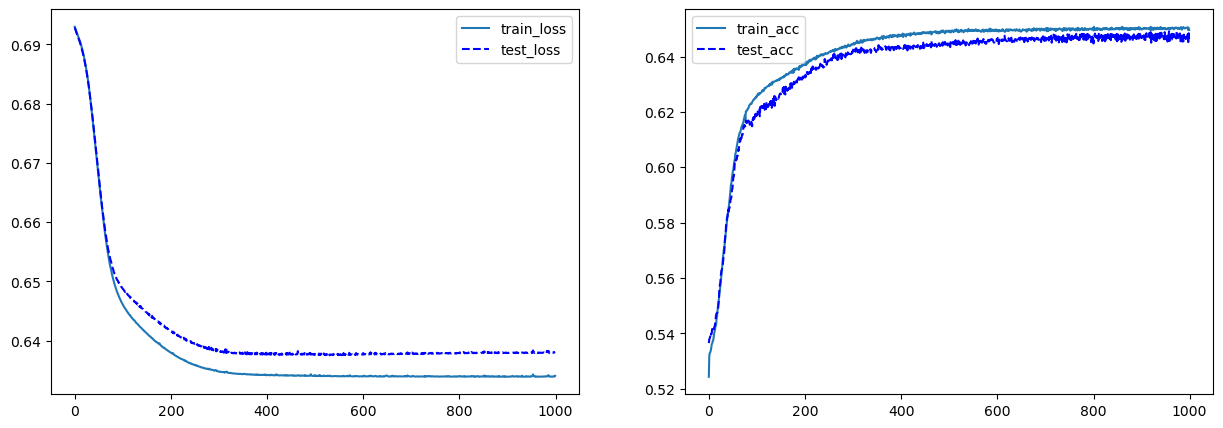

In [93]:
graficar(historia1)

### UNDERFITTING

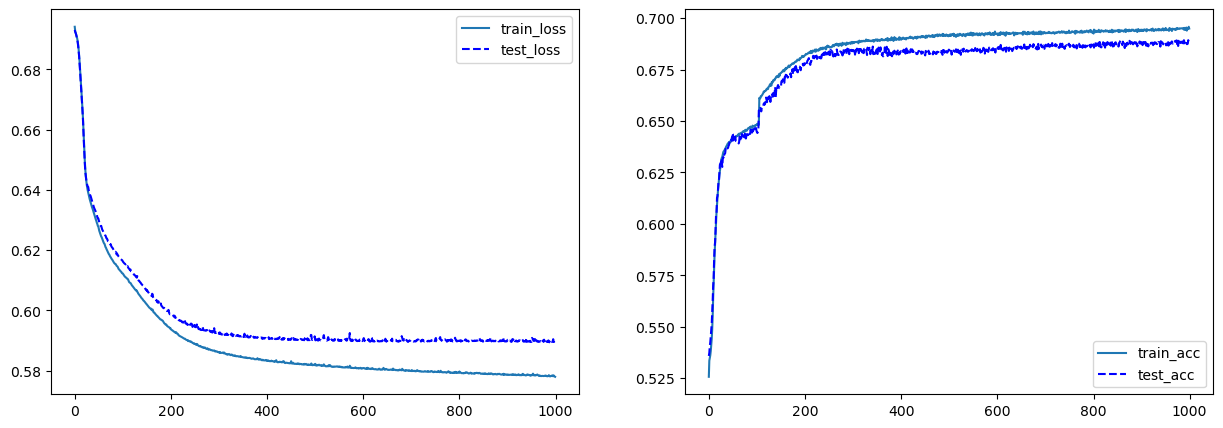

In [95]:
graficar(historia2)

### NORMAL

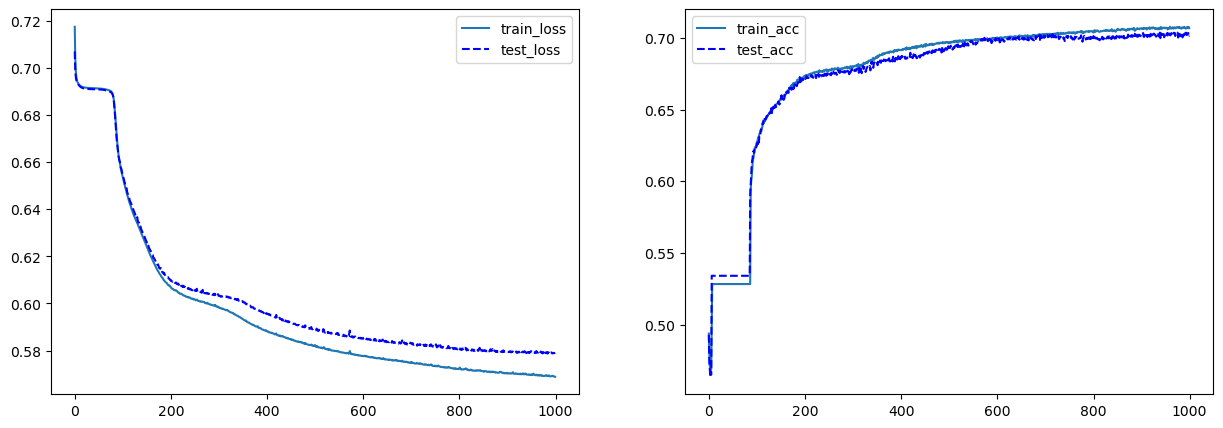

In [96]:
graficar(historia3)

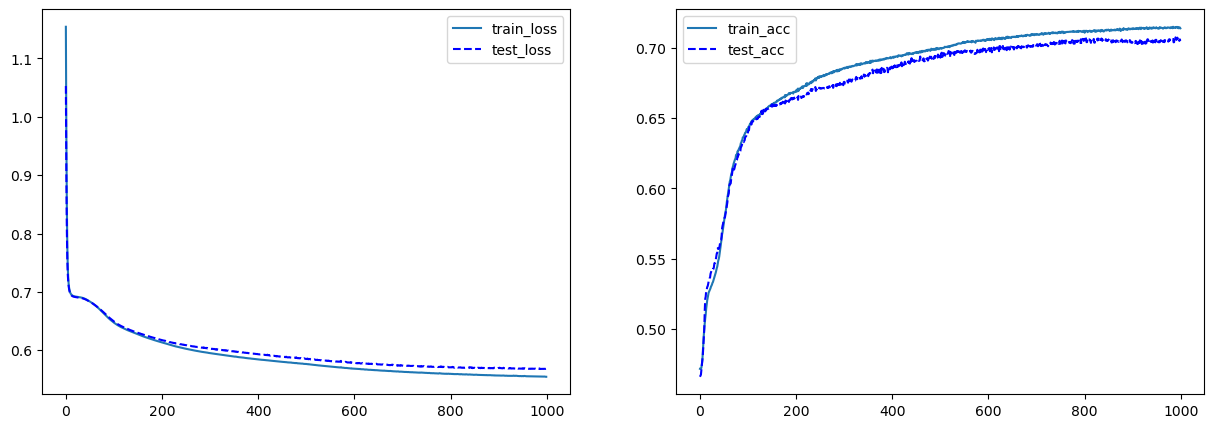

In [97]:
graficar(historia4)

### OVERFITTING

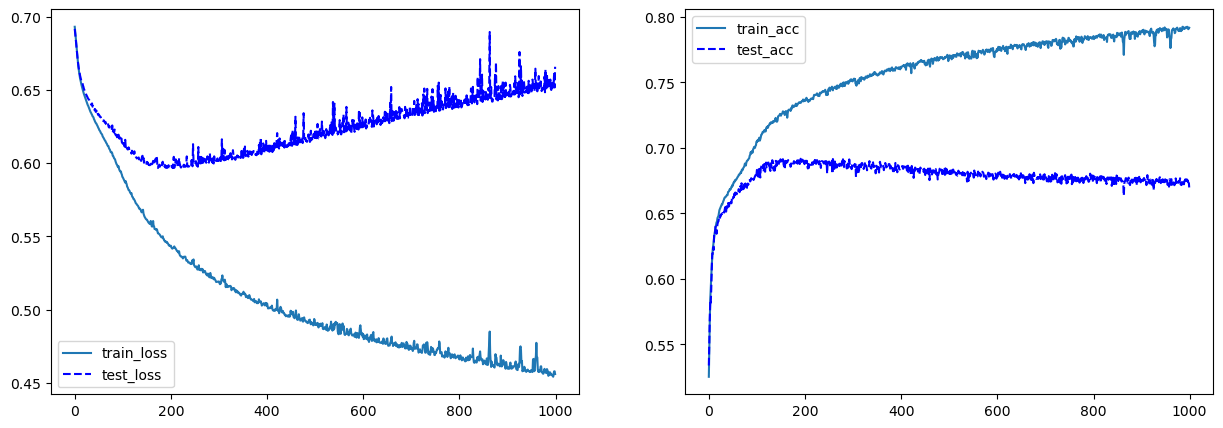

In [98]:
graficar(historia5)

# Reducción del *overfitting*

A partir del `modelo_5` crearemos dos modelos adicionales con ligeras variaciones:

- `modelo_5a`: se agregará *Drop out* al ``modelo_5``
- `modelo_5b`: se agregará *weight regularization* al `modelo_5`

In [101]:
# modelo_5a
from tensorflow.keras.layers import Dropout
modelo5a = Sequential()
modelo5a.add(Dense(512, activation='relu', input_shape=(DIM_ENTRADA,), name='capa_1'))
modelo5a.add(Dropout(0.5))
modelo5a.add(Dense(512, activation='relu', name='capa_2'))
modelo5a.add(Dropout(0.5))
modelo5a.add(Dense(512, activation='relu', name='capa_3'))
modelo5a.add(Dropout(0.5))
modelo5a.add(Dense(512, activation='relu', name='capa_4'))
modelo5a.add(Dropout(0.5))
modelo5a.add(Dense(DIM_SALIDA, activation='sigmoid', name='capa_salida'))
modelo5a._name = 'modelo_5a'
modelo5a.summary()

Model: "modelo_5a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 capa_1 (Dense)              (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 capa_2 (Dense)              (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 capa_3 (Dense)              (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 capa_4 (Dense)              (None, 512)               26

In [103]:
# modelo_5b
from tensorflow.keras.regularizers import l2

modelo5b = Sequential()
modelo5b.add(Dense(512, activation='relu', input_shape=(DIM_ENTRADA,),
                   kernel_regularizer=l2(1e-3), name='capa_1'))
modelo5b.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-3), name='capa_2'))
modelo5b.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-3), name='capa_3'))
modelo5b.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-3), name='capa_4'))
modelo5b.add(Dense(DIM_SALIDA, activation='sigmoid', name='capa_salida'))
modelo5b._name = 'modelo_5b'
modelo5b.summary()

Model: "modelo_5b"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 capa_1 (Dense)              (None, 512)               14848     
                                                                 
 capa_2 (Dense)              (None, 512)               262656    
                                                                 
 capa_3 (Dense)              (None, 512)               262656    
                                                                 
 capa_4 (Dense)              (None, 512)               262656    
                                                                 
 capa_salida (Dense)         (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [104]:
# Entrenamiento
historia5a = compilar_entrenar(modelo5a)
historia5b = compilar_entrenar(modelo5b)

modelo_5a - precisión entrenamiento/prueba: 91.23%/71.13%
modelo_5b - precisión entrenamiento/prueba: 96.61%/66.42%


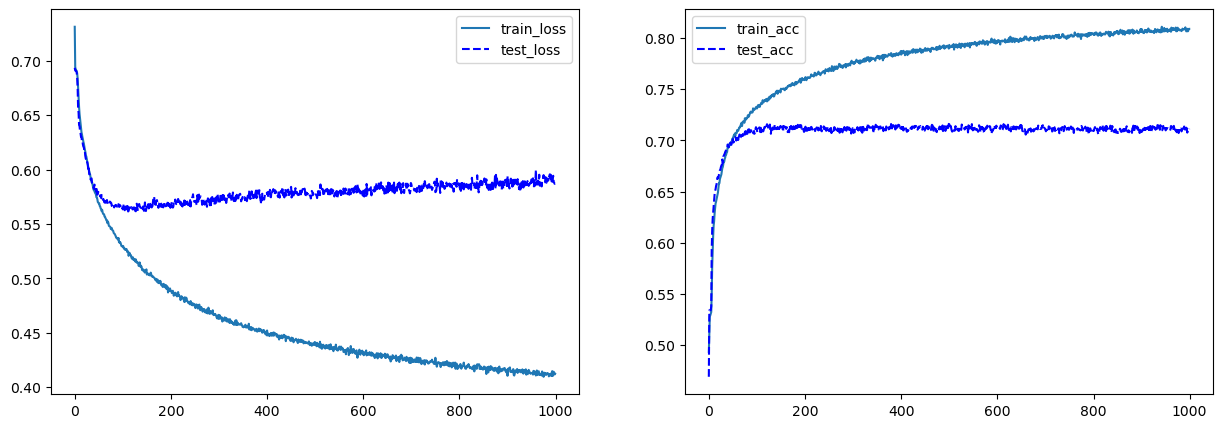

In [105]:
graficar(historia5a)

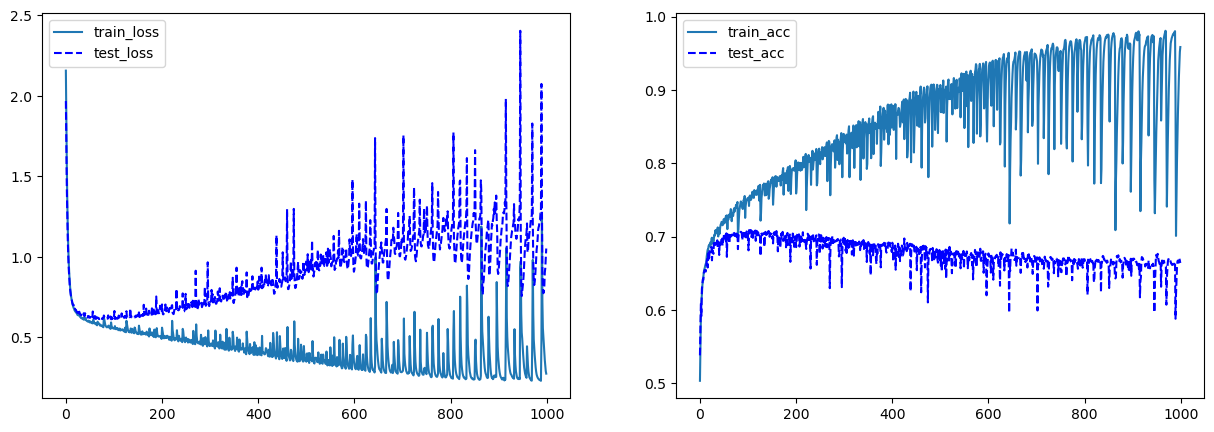

In [106]:
graficar(historia5b)